In [1]:
# Enable auto reloading of notebook
%load_ext autoreload
%autoreload 2

In [2]:
import random

import torchvision.models as models

from facenet_pytorch import MTCNN, InceptionResnetV1
from utils import *
from dog_breed_classifier import *
from networks import *
from dog_app import *

In [3]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

Using cuda:0


In [4]:
# Load dog dataset
train_files, _, dog_targets_map = load_dog_dataset("data/dogImages/train")
valid_files, _, _ = load_dog_dataset("data/dogImages/valid")
test_files, _, _ = load_dog_dataset("data/dogImages/test")

# Load list of dog names
dog_names = dog_targets_map.keys()

# Print statistics about the dataset
print("There are %d total dog categories." % len(dog_names))
print(
    "There are %s total dog images.\n"
    % len(np.hstack([train_files, valid_files, test_files]))
)
print("There are %d training dog images." % len(train_files))
print("There are %d validation dog images." % len(valid_files))
print("There are %d test dog images." % len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [5]:
# Load human dataset
human_files = load_human_dataset("data/lfw")
random.shuffle(human_files)

# Print statistics about the dataset
print("There are %d total human images." % len(human_files))

There are 13233 total human images.


Number of detected faces:  1


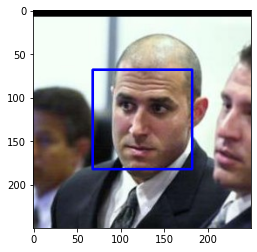

In [6]:
# Haarcascade
face_cascade = cv2.CascadeClassifier(
    "pretrained/haarcascades/haarcascade_frontalface_alt.xml"
)
print(
    "Number of detected faces: ",
    get_num_faces_haarcascade(str(human_files[0]), face_cascade),
)
visualize_faces_haarcascade(str(human_files[0]), face_cascade)

In [ ]:
# PyTorch
mtcnn = MTCNN(image_size=250, keep_all=True, device=device)
print("Number of detected faces: ", get_num_faces_mtcnn(str(human_files[0]), mtcnn))
visualize_faces_mtcnn(str(human_files[0]), mtcnn)

In [ ]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


def assess_human_detector(human_files, dog_files, get_num_faces):
    num_true_positive = 0
    y_true = [0] * len(human_files) + [1] * len(dog_files)
    y_pred = []
    for x in human_files:
        next_pred = get_num_faces(x) > 0
        y_pred.append(0) if next_pred else y_pred.append(1)
        num_true_positive += 1 if next_pred else 0

    num_false_positive = 0
    for x in dog_files:
        next_pred = get_num_faces(x) > 0
        y_pred.append(0) if next_pred else y_pred.append(1)
        num_false_positive += 1 if next_pred else 0

    print(
        "Human faces correctly detected: {}/{}".format(
            num_true_positive, len(human_files)
        )
    )
    print(
        "Dog faces wrongly detected as human: {}/{}".format(
            num_false_positive, len(dog_files)
        )
    )
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=0
    )
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Fscore: {}".format(fscore))

In [ ]:
print("Using Haar Cascade")
assess_human_detector(
    human_files_short,
    dog_files_short,
    lambda x: get_num_faces_haarcascade(str(x), face_cascade),
)

In [ ]:
print("Using MTCNN")
assess_human_detector(
    human_files_short, dog_files_short, lambda x: get_num_faces_mtcnn(str(x), mtcnn)
)

In [ ]:
def assess_dog_detector(human_files, dog_files, detector, device):
    num_true_positive = 0
    y_true = [1] * len(dog_files) + [0] * len(human_files)
    y_pred = []
    for x in dog_files:
        next_pred = detect_dog_imagenet(str(x), detector, device)
        y_pred.append(1) if next_pred else y_pred.append(0)
        num_true_positive += 1 if next_pred else 0

    num_false_positive = 0
    for x in human_files:
        next_pred = detect_dog_imagenet(str(x), detector, device)
        y_pred.append(1) if next_pred else y_pred.append(0)
        num_false_positive += 1 if next_pred else 0

    print("Dogs correctly detected: {}/{}".format(num_true_positive, len(dog_files)))
    print(
        "Humans wrongly classified as dog: {}/{}".format(
            num_false_positive, len(human_files)
        )
    )
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Fscore: {}".format(fscore))

In [ ]:
print("Using Resnet50")
resnet50 = models.resnet50(pretrained=True).to(device).eval()
assess_dog_detector(human_files_short, dog_files_short, resnet50, device)

In [ ]:
print("Using VGG16")
vgg16 = models.vgg16(pretrained=True).to(device).eval()
assess_dog_detector(human_files_short, dog_files_short, vgg16, device)

In [ ]:
print("Using Inception V3")
inception_v3 = models.inception_v3(pretrained=True).to(device).eval()
assess_dog_detector(human_files_short, dog_files_short, inception_v3, device)

In [ ]:
simple_net = SimpleNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_net.parameters(), lr=3e-4)

In [ ]:
print(simple_net)

In [ ]:
dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
    data_path="data/dogImages", model=simple_net, save_prefix="scratch"
)

In [ ]:
# dog_breed_classifier_pipeline.train(num_epochs=10, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [ ]:
dog_breed_classifier_pipeline.load(
    "pretrained/models/scratch_2021_10_09_230956979794_03339_best.pt"
)

In [ ]:
dog_breed_classifier_pipeline.evaluate(device)

In [ ]:
# vgg16_dogbreed_net = VGGTransferLearningNet(vgg16).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(vgg16_dogbreed_net.parameters(), lr=3e-4)

In [ ]:
# dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
#     data_path="data/dogImages", model=vgg16_dogbreed_net, save_prefix="vgg16_tf"
# )

In [ ]:
# dog_breed_classifier_pipeline.train(num_epochs=10, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [ ]:
dog_breed_classifier_pipeline.classify(str(train_files[0]), device)

In [ ]:
dog_breed_classifier_fn = lambda x : dog_breed_classifier_pipeline.classify(x, device)
dog_detector_fn = lambda x : detect_dog_imagenet(x, vgg16, device)
human_detector_fn = lambda x: get_num_faces_haarcascade(str(x), face_cascade)
dog_app = DogApp(dog_breed_classifier_fn, dog_detector_fn, human_detector_fn)

In [ ]:
dog_app.run(str(human_files[0]))